# Filament Decorrelation Analysis
Analysis of various decorellation parameters.

In [1]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
    
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import interpolate

import os
import pyfilaments.analysisutils as analysis
import imp
imp.reload(analysis)
%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm

rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 12})

publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures'


dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', 're', 'enum', 

## Load a filament simulation


In [282]:

# root_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20'
# track_folder = 'SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.6794871794871793_activityTime_750_simType_point'
# file = 'SimResults_00.hdf5'

# Aperiodic
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point/SimResults_00.hdf5'
# folder, *rest = os.path.split(os.path.join(root_folder, track_folder, file))

# Aperiodic to Periodic transition (Transient Chaos?)
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.615384615384615_activityTime_750_simType_point/SimResults_01.hdf5'


# Period 6
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point/SimResults_00.hdf5'

# Aperiodic (smallest activity strength)
file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.0769230769230769_activityTime_750_simType_point/SimResults_00.hdf5'

filament = analysis.analysisTools(file = file)

file_path = filament.analysis_folder

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.999733340444255
No:of particles : 32
No:of time points : 37501
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.0769230769230769_activityTime_750_simType_point
Data file SimResults_00.hdf5


In [283]:
# Filament tip orientation decorrelation

# Find start and stop indices of compressive and extensional phases
phase_value_compression = 0

# Phase indices at start of compression
delta_phase = 2*np.pi*np.mean(filament.Time[1:] - filament.Time[:-1])/filament.activity_timescale # Smallest change in phase

abs_val_array = np.abs(filament.derived_data['Phase'] - phase_value_compression)
constant_phase_mask = abs_val_array <= 0.5*delta_phase

time_points = np.array(range(0, filament.Nt))
constant_phase_compression = time_points[constant_phase_mask]

# Phase indices at start of extension
phase_value_extension = np.pi

abs_val_array = np.abs(filament.derived_data['Phase'] - phase_value_extension)

min_phase = np.min(abs_val_array)
constant_phase_mask = abs_val_array <= min_phase
constant_phase_extension = np.array(time_points[constant_phase_mask])

# Keep only indices separated by more than 1

temp_array = []

for ii in range(len(constant_phase_extension)):
    
    if(ii == len(constant_phase_extension)-1):
        temp_array.append(constant_phase_extension[ii])
        
    elif(constant_phase_extension[ii+1] - constant_phase_extension[ii] > 1):
        temp_array.append(constant_phase_extension[ii])
        
    
    
constant_phase_extension = np.array(temp_array)
        
    
# Find total number of activity cycles
filament.activity_cycles = int(filament.Time[-1]/filament.activity_timescale)

print(filament.activity_cycles)

500


In [284]:
# Store (Start, End) indices for compression phase and extension phase

start_end_compression = np.empty((2, filament.activity_cycles), dtype = int)
start_end_extension = np.empty((2, filament.activity_cycles), dtype = int)


In [285]:
for ii in range(filament.activity_cycles):
    
    start_end_compression[:,ii] = constant_phase_compression[ii], constant_phase_extension[ii]
    start_end_extension[:,ii] = constant_phase_extension[ii], constant_phase_compression[ii+1]
    
    assert(start_end_compression[1,ii]-start_end_compression[0,ii] >0)
    assert(start_end_extension[1,ii]-start_end_extension[0,ii] >0)
    
    

In [286]:
# Calculate the filament tip orientations for all times
filament.compute_tip_angle()

In [287]:
# Find the minimum time intervals over all compression and extensional phases
T_min_comp = filament.Time[-1]
T_min_ext = filament.Time[-1]

for ii in range(filament.activity_cycles):
    print(ii)
    comp_start_index = start_end_compression[0, ii]
    comp_end_index = start_end_compression[1, ii]
    
    ext_start_index = start_end_extension[0, ii]
    ext_end_index = start_end_extension[1, ii]
    
#     print(filament.Time[comp_end_index])
#     print(filament.Time[ext_end_index])
#     print(filament.Time[comp_end_index]-filament.Time[comp_start_index])
#     print(filament.Time[ext_end_index]-filament.Time[ext_start_index])

#     print(filament.Time[comp_start_index:comp_end_index]-filament.Time[comp_start_index])
#     print(filament.Time[ext_start_index:ext_end_index]-filament.Time[ext_start_index])
    
#     print(filament.Time[comp_end_index] - filament.Time[comp_start_index])
#     print(filament.Time[ext_end_index] - filament.Time[ext_start_index])
    # Take the min of the current value and the time interval duration during the current compressive phase
    T_min_comp = min(T_min_comp, filament.Time[comp_end_index] - filament.Time[comp_start_index])
    
    T_min_ext = min(T_min_ext, filament.Time[ext_end_index] - filament.Time[ext_start_index])

print(T_min_comp)
print(T_min_ext)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [288]:
# Store tip angles on a uniform grid by interpolation
from scipy import interpolate

n_time = 500
filament.duty_cycle = 0.5
tip_angles_compression = np.empty((filament.activity_cycles, n_time), dtype = float)
tip_angles_extension = np.empty((filament.activity_cycles, n_time), dtype = float)

time_array_comp = np.linspace(0, T_min_comp, n_time)
time_array_ext = np.linspace(0, T_min_ext, n_time)

for ii in range(filament.activity_cycles):
    
    comp_start_index = start_end_compression[0, ii]
    comp_end_index = start_end_compression[1, ii]
    
    ext_start_index = start_end_extension[0, ii]
    ext_end_index = start_end_extension[1, ii]
    
    # Interpolate
    compression_func = interpolate.interp1d(filament.Time[comp_start_index:comp_end_index+1]-filament.Time[comp_start_index], filament.derived_data['tip angle'][comp_start_index:comp_end_index+1])
    tip_angles_compression[ii, :] = compression_func(time_array_comp)
    
    extension_func = interpolate.interp1d(filament.Time[ext_start_index:ext_end_index+1]-filament.Time[ext_start_index], filament.derived_data['tip angle'][ext_start_index:ext_end_index+1])
    tip_angles_extension[ii, :] = extension_func(time_array_ext)

<IPython.core.display.Javascript object>


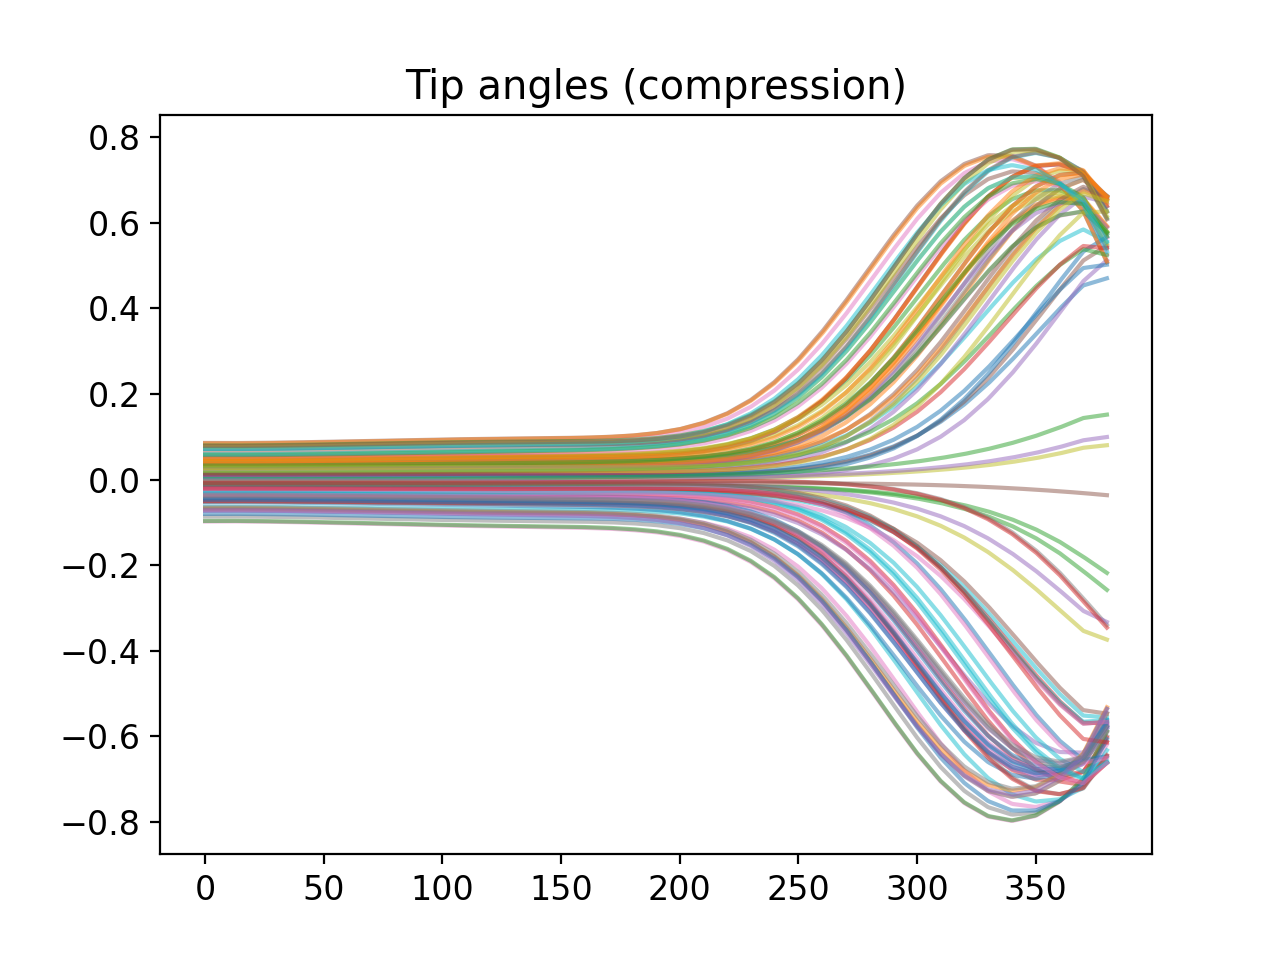

In [289]:
# Plot the tip angles during Compression and Extension

plt.figure()
for ii in range(400, 500):
    
    plt.plot(time_array_comp, tip_angles_compression[ii, :], alpha = 0.5)
    

plt.title('Tip angles (compression)')
plt.show()



<IPython.core.display.Javascript object>


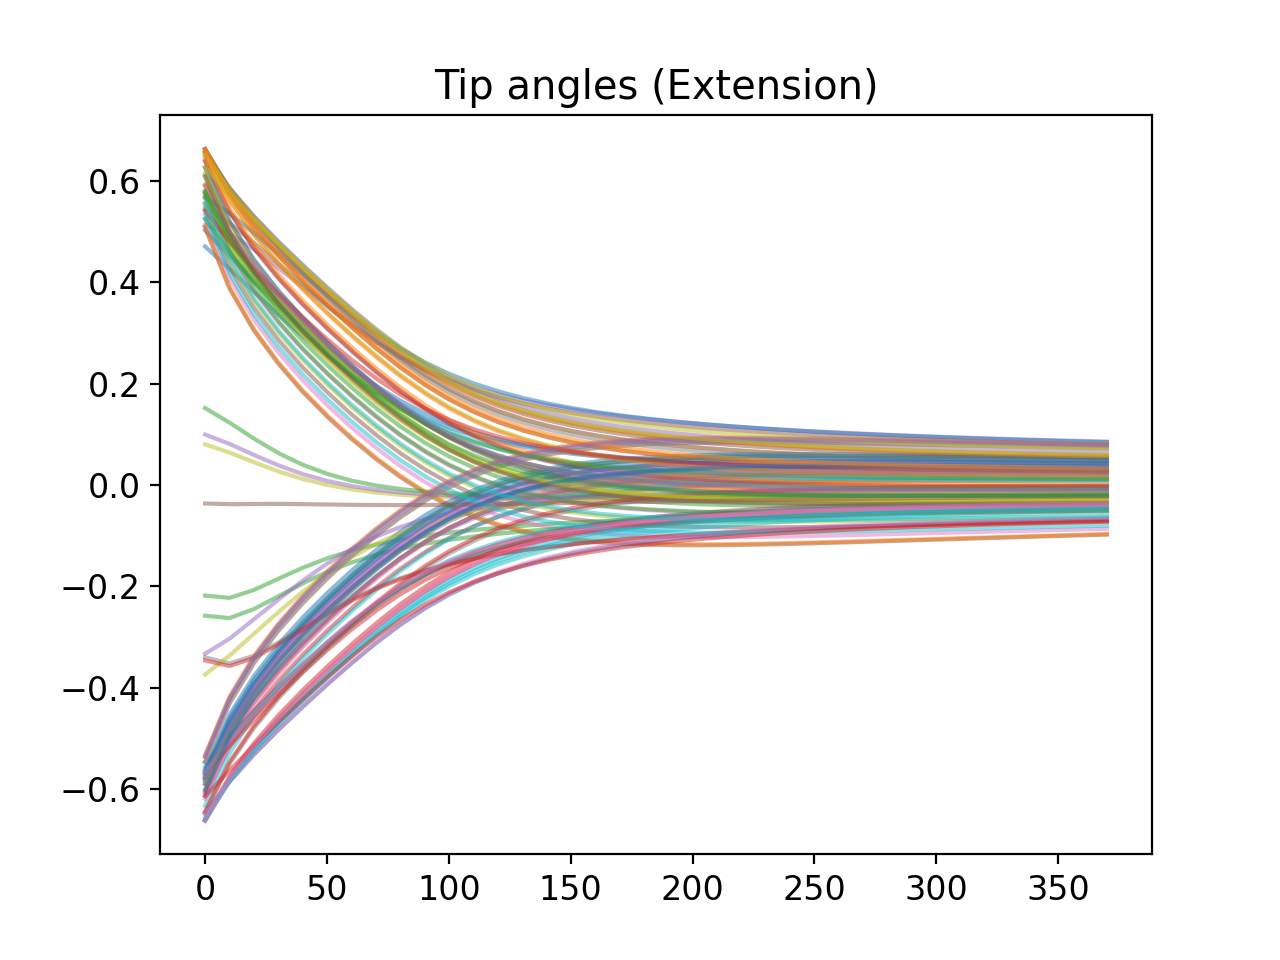

In [300]:
plt.figure()
for ii in range(400, 500):
    
    plt.plot(time_array_ext, tip_angles_extension[ii, :], alpha = 0.5)
    

plt.title('Tip angles (Extension)')
plt.show()

## Return map of Filament tip angle ($\theta_{n+1}$ vs $\theta_n$)


In [301]:
tip_angle_phase_0 = filament.derived_data['tip angle'][constant_phase_compression]

time_array = filament.Time[constant_phase_compression]
activity_cycle = np.array(time_array/filament.activity_timescale, dtype = int)

<IPython.core.display.Javascript object>


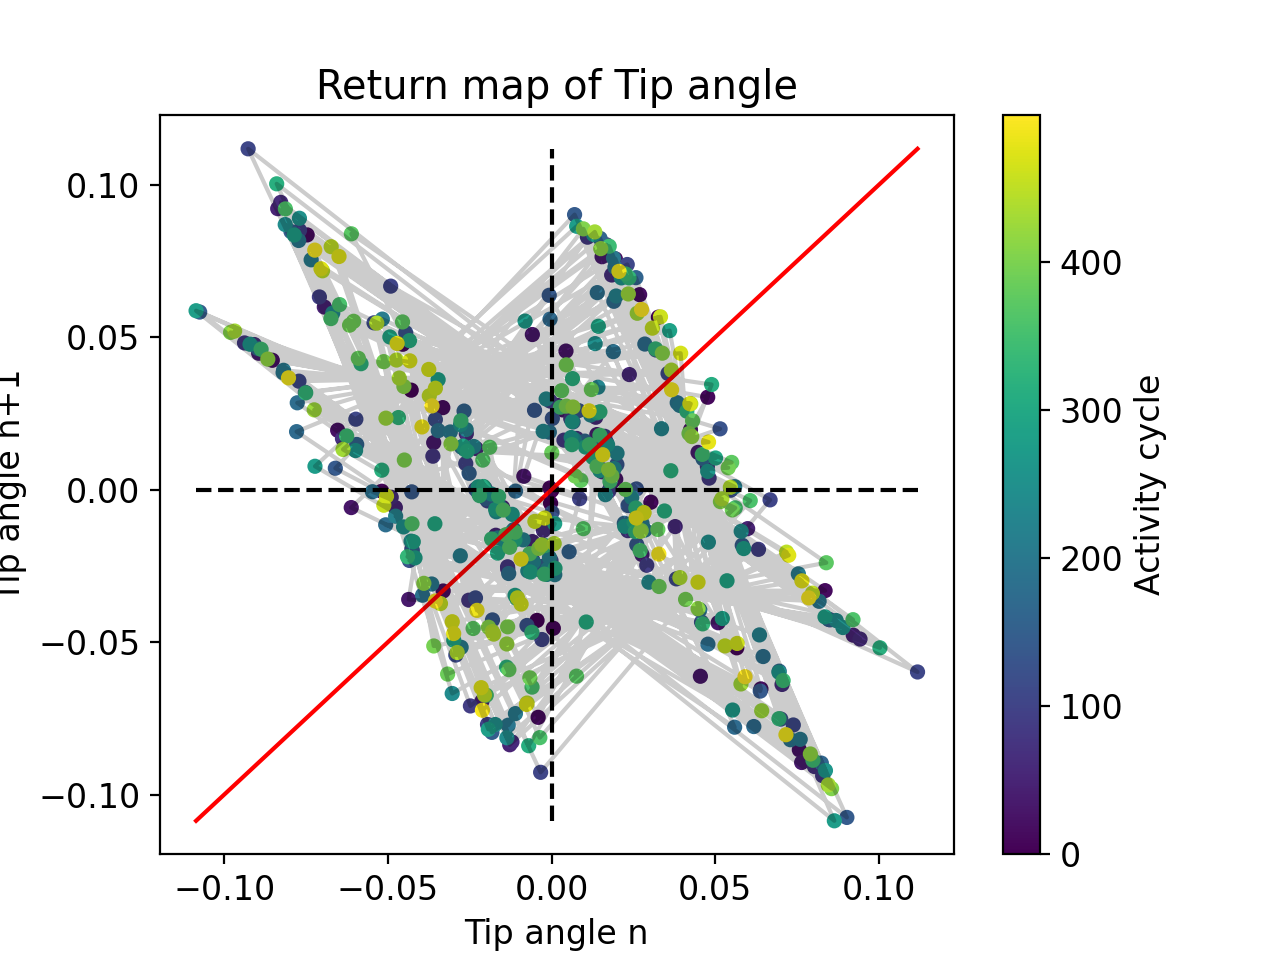

In [302]:
plt.figure()
title = 'Tip angle'

angle_min = np.min(tip_angle_phase_0)
angle_max = np.max(tip_angle_phase_0)

diag_line_x = np.linspace(angle_min, angle_max, 20)
diag_line_y = diag_line_x

ax2 = plt.plot(diag_line_x, diag_line_y, 'r-')
ax2 = plt.hlines(0, angle_min, angle_max, color = 'k', linestyle = '--')
ax2 = plt.vlines(0, angle_min, angle_max, color = 'k', linestyle = '--')

ax2 = plt.plot(tip_angle_phase_0[:-1], tip_angle_phase_0[1:], color = 'k', alpha =0.2)

ax1 = plt.scatter(tip_angle_phase_0[:-1], tip_angle_phase_0[1:], 20, c = activity_cycle[:-1])




plt.xlabel('Tip angle '+'n')
plt.ylabel('Tip angle '+'n+1')
plt.title('Return map of '+ title)
cbar = plt.colorbar(ax1)
cbar.ax.set_ylabel('Activity cycle')


file_path = filament.analysis_folder
if(not os.path.exists(file_path)):
    os.makedirs(file_path)

file_name = filament.dataName[:-5] +'_'+title
plt.savefig(os.path.join(file_path, file_name + '.png'), dpi = 300, bbox_inches = 'tight')
plt.savefig(os.path.join(file_path, file_name + '.svg'), dpi = 300, bbox_inches = 'tight')

plt.show()

## Return Map of Filament Base Tip Angle

In [303]:
filament.compute_base_tip_angle()

base_tip_angle_phase_0 = filament.derived_data['base tip angle'][constant_phase_compression]

<IPython.core.display.Javascript object>


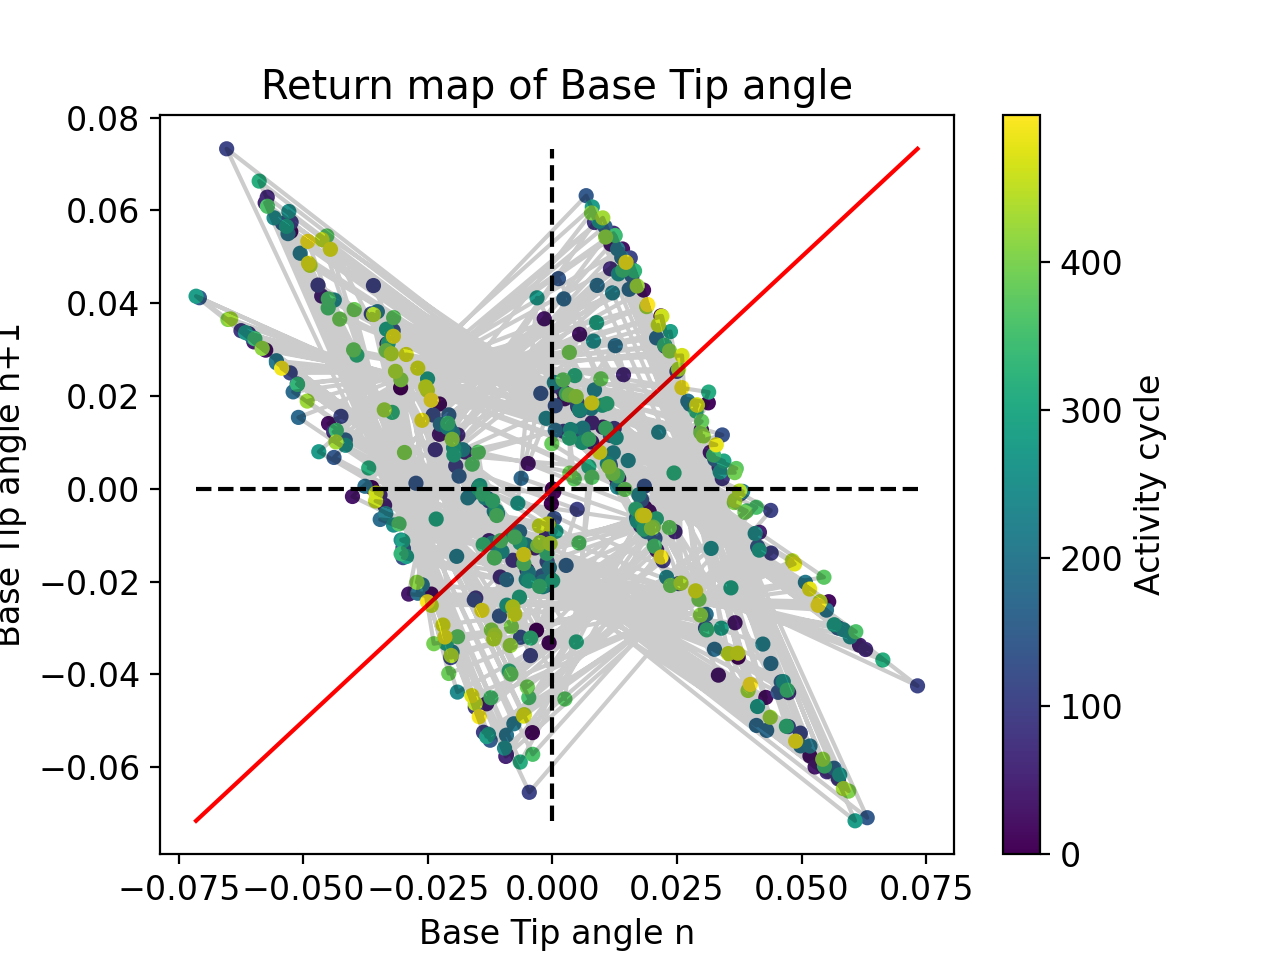

In [304]:
plt.figure()
title = 'Base Tip angle'

angle_min = np.min(base_tip_angle_phase_0)
angle_max = np.max(base_tip_angle_phase_0)

diag_line_x = np.linspace(angle_min, angle_max, 20)
diag_line_y = diag_line_x

ax2 = plt.plot(diag_line_x, diag_line_y, 'r-')
ax2 = plt.hlines(0, angle_min, angle_max, color = 'k', linestyle = '--')
ax2 = plt.vlines(0, angle_min, angle_max, color = 'k', linestyle = '--')

ax1 = plt.scatter(base_tip_angle_phase_0[:-1], base_tip_angle_phase_0[1:], 20, c = activity_cycle[:-1])

ax2 = plt.plot(base_tip_angle_phase_0[:-1], base_tip_angle_phase_0[1:], color = 'k', alpha =0.2)



plt.xlabel('Base Tip angle '+'n')
plt.ylabel('Base Tip angle '+'n+1')
plt.title('Return map of '+ title)
cbar = plt.colorbar(ax1)
cbar.ax.set_ylabel('Activity cycle')


file_path = filament.analysis_folder
if(not os.path.exists(file_path)):
    os.makedirs(file_path)

file_name = filament.dataName[:-5] +'_'+title
plt.savefig(os.path.join(file_path, file_name + '.png'), dpi = 300, bbox_inches = 'tight')
plt.savefig(os.path.join(file_path, file_name + '.svg'), dpi = 300, bbox_inches = 'tight')

plt.show()

## Tangent angle dynamics over whole simulation

<IPython.core.display.Javascript object>


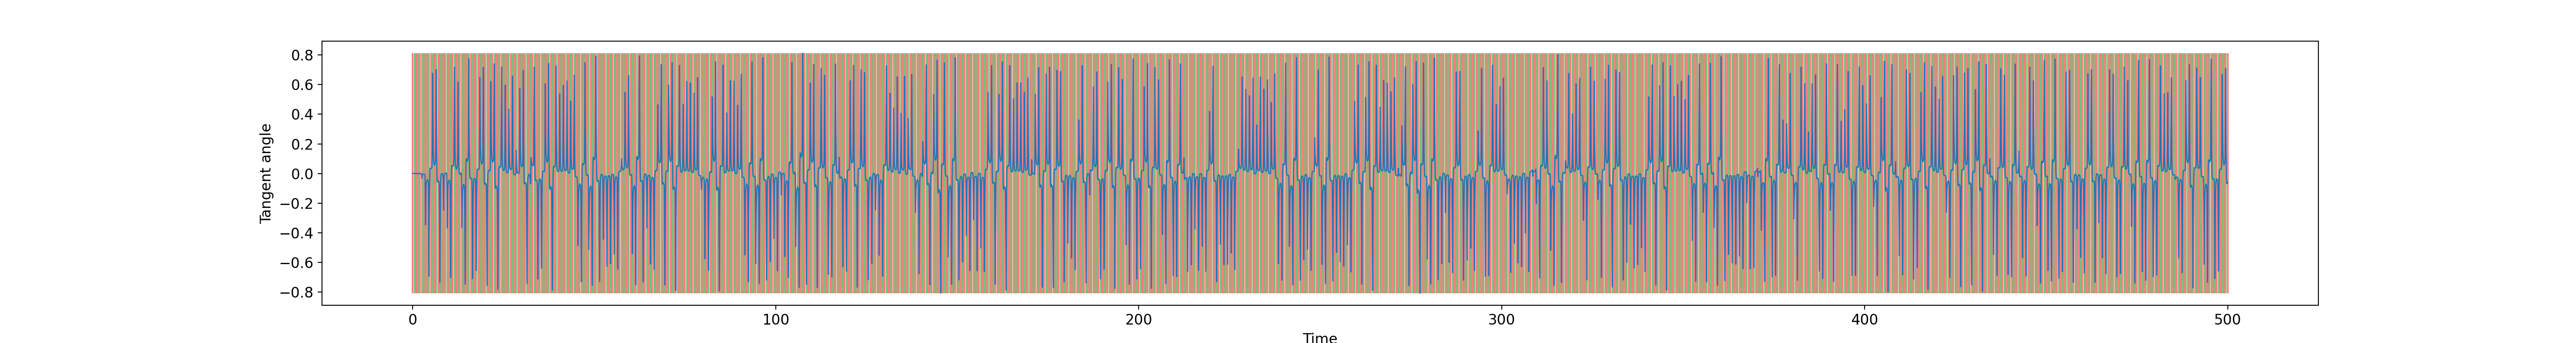

In [305]:
time_array = range(int(filament.Nt))
plt.figure(figsize = (30,4))
plt.plot(filament.Time/filament.activity_timescale, filament.derived_data['tip angle'], linewidth = 1)
plt.vlines(filament.Time[constant_phase_compression]/filament.activity_timescale, min(filament.derived_data['tip angle']), max(filament.derived_data['tip angle']), 'r', alpha = 0.5)
plt.vlines(filament.Time[constant_phase_extension]/filament.activity_timescale, min(filament.derived_data['tip angle']), max(filament.derived_data['tip angle']), 'g', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('Tangent angle')
ax = plt.gca()
# ax.set_aspect(1)
# plt.savefig(os.path.join(file_path, filament.dataName[:-5]+'TangentAngle_At_Tip.png'), dpi = 300)
plt.show()

<IPython.core.display.Javascript object>


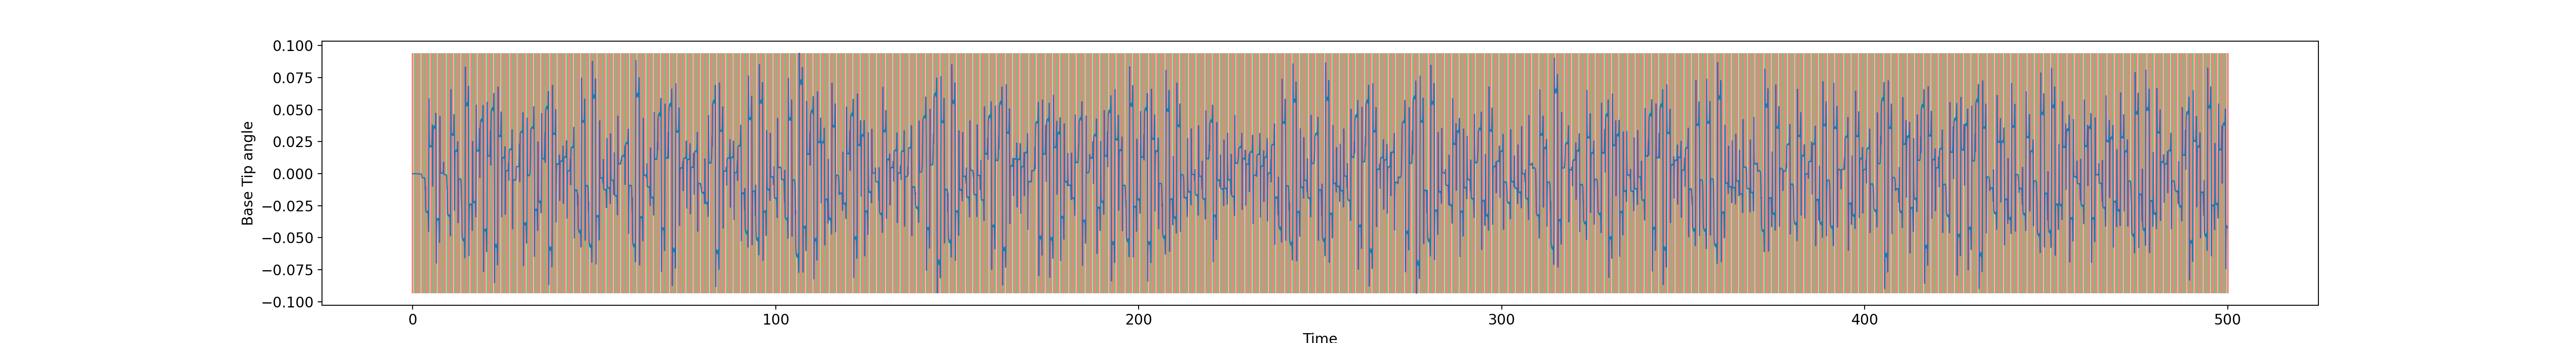

In [306]:
## Base-tip angle over whole simulation

time_array = range(int(filament.Nt))
plt.figure(figsize = (30,4))
plt.plot(filament.Time/filament.activity_timescale, filament.derived_data['base tip angle'], linewidth = 1)
plt.vlines(filament.Time[constant_phase_compression]/filament.activity_timescale, min(filament.derived_data['base tip angle']), max(filament.derived_data['base tip angle']), 'r', alpha = 0.5)
plt.vlines(filament.Time[constant_phase_extension]/filament.activity_timescale, min(filament.derived_data['base tip angle']), max(filament.derived_data['base tip angle']), 'g', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('Base Tip angle')
ax = plt.gca()
# ax.set_aspect(1)
# plt.savefig(os.path.join(file_path, filament.dataName[:-5]+'TangentAngle_At_Tip.png'), dpi = 300)
plt.show()

In [307]:
# Find the local maxima and minima of the Tip angles time series
min_peak = min(filament.derived_data['tip angle'])
max_peak = max(filament.derived_data['tip angle'])
max_peaks, props = signal.find_peaks(filament.derived_data['tip angle'], (0.2*max_peak, max_peak))

min_peaks, props = signal.find_peaks(-filament.derived_data['tip angle'], (-0.2*min_peak, -min_peak))

print(max_peaks)
print(min_peaks)

[  412   485   862   937  1160  1387  1459  1613  1684  1836  1912  1988
  2062  2213  2285  2510  2738  2809  2961  3037  3112  3187  3263  3336
  3560  3784  4387  4461  4684  5063  5134  5288  5359  5511  5588  5662
  5737  5812  5886  6188  6259  6411  6488  6562  6637  6713  6786  7010
  7234  7836  8059  8213  8284  8437  8511  8736  9038  9109  9262  9335
  9786  9862  9938 10012 10088 10162 10238 10311 10540 10609 10763 10833
 10985 11209 11888 11959 12113 12184 12336 12412 12487 12562 12637 12712
 12863 12934 13087 13159 13312 13385 13763 13835 14062 14135 14363 14434
 14587 14662 14884 15113 15184 15337 15412 15635 15861 16463 16535 17063
 17137 17212 17287 17362 17438 17512 17587 17662 17738 17811 18035 18259
 18639 18711 18934 19463 19534 19688 19759 19911 19988 20062 20137 20212
 20287 20439 20509 20663 20733 20885 21109 21562 21635 22014 22085 22311
 22388 22462 22537 23362 23437 23659 23887 23963 24037 24112 24337 24412
 24637 24709 24862 24935 25538 25609 25763 25834 25

<IPython.core.display.Javascript object>


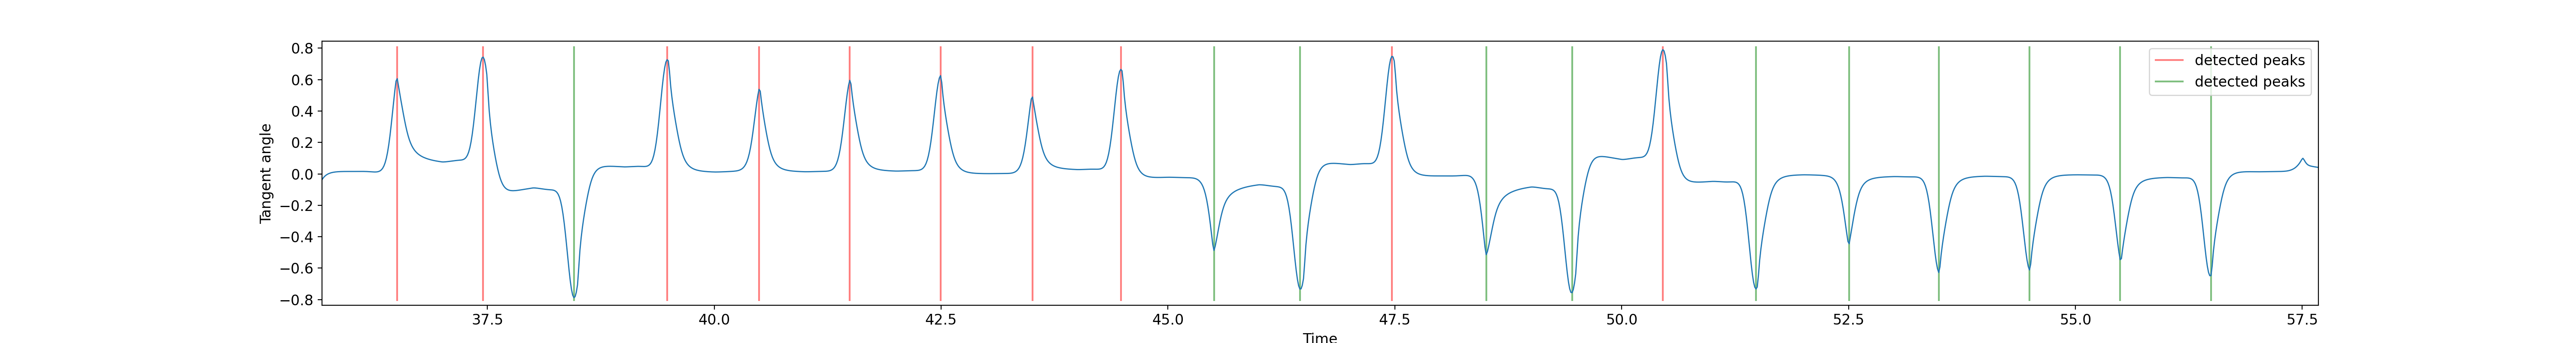

In [308]:
plt.figure(figsize = (30,4))
plt.plot(filament.Time/filament.activity_timescale, filament.derived_data['tip angle'], linewidth = 1)
plt.vlines(filament.Time[max_peaks]/filament.activity_timescale, min(filament.derived_data['tip angle']), max(filament.derived_data['tip angle']), 'r', alpha = 0.5, label = 'detected peaks')
plt.vlines(filament.Time[min_peaks]/filament.activity_timescale, min(filament.derived_data['tip angle']), max(filament.derived_data['tip angle']), 'g', alpha = 0.5, label = 'detected peaks')

plt.xlabel('Time')
plt.ylabel('Tangent angle')
plt.legend()
ax = plt.gca()
# ax.set_aspect(1)
# plt.savefig(os.path.join(file_path, filament.dataName[:-5]+'TangentAngle_At_Tip.png'), dpi = 300)
plt.show()

<IPython.core.display.Javascript object>


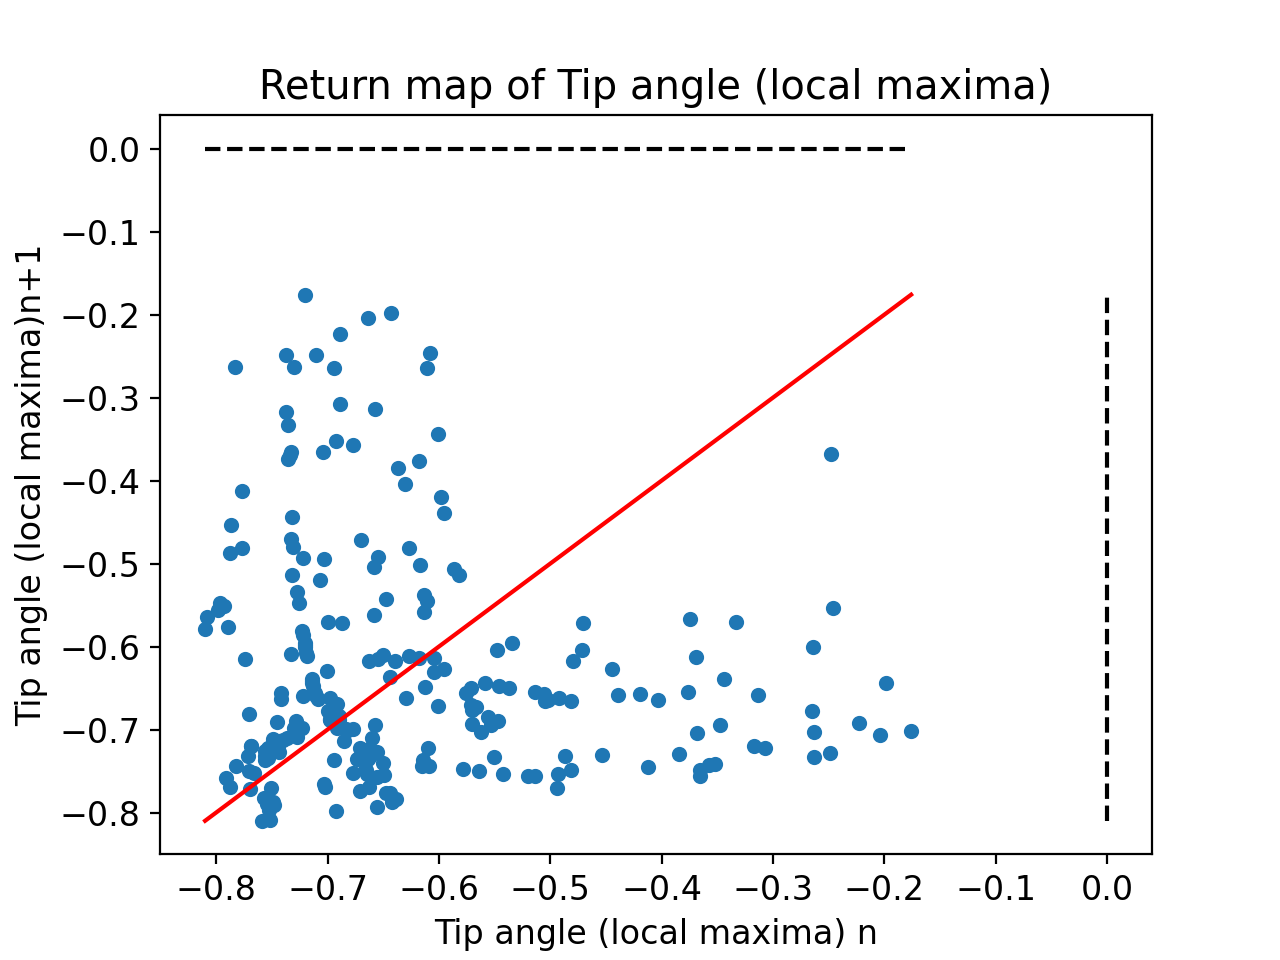

In [313]:
## Return map of the maxima of the tip angles

plt.figure()
title = 'Tip angle (local maxima)'

all_peaks = np.sort(np.concatenate((min_peaks, max_peaks)))

# tip_angle_maxima = filament.derived_data['tip angle'][all_peaks]

tip_angle_maxima = filament.derived_data['tip angle'][min_peaks]
# tip_angle_maxima = tip_angle_maxima[-100:]

angle_min = np.min(tip_angle_maxima)
angle_max = np.max(tip_angle_maxima)

diag_line_x = np.linspace(angle_min, angle_max, 20)
diag_line_y = diag_line_x

ax2 = plt.plot(diag_line_x, diag_line_y, 'r-')
ax2 = plt.hlines(0, angle_min, angle_max, color = 'k', linestyle = '--')
ax2 = plt.vlines(0, angle_min, angle_max, color = 'k', linestyle = '--')

ax1 = plt.scatter(tip_angle_maxima[:-1], tip_angle_maxima[1:], 20)




plt.xlabel('Tip angle (local maxima) '+'n')
plt.ylabel('Tip angle (local maxima)'+'n+1')
plt.title('Return map of '+ title)
# cbar = plt.colorbar(ax1)
# cbar.ax.set_ylabel('Activity cycle')


file_path = filament.analysis_folder
if(not os.path.exists(file_path)):
    os.makedirs(file_path)

file_name = filament.dataName[:-5] +'_'+title
# plt.savefig(os.path.join(file_path, file_name + '.png'), dpi = 300, bbox_inches = 'tight')
# plt.savefig(os.path.join(file_path, file_name + '.svg'), dpi = 300, bbox_inches = 'tight')

plt.show()

In [260]:
len(all_peaks)

479

In [257]:
max_peaks

array([  412,   485,   862,   937,  1160,  1387,  1459,  1613,  1684,
        1836,  1912,  1988,  2062,  2213,  2285,  2510,  2738,  2809,
        2961,  3037,  3112,  3187,  3263,  3336,  3560,  3784,  4387,
        4461,  4684,  5063,  5134,  5288,  5359,  5511,  5588,  5662,
        5737,  5812,  5886,  6188,  6259,  6411,  6488,  6562,  6637,
        6713,  6786,  7010,  7234,  7836,  8059,  8213,  8284,  8437,
        8511,  8736,  9038,  9109,  9262,  9335,  9786,  9862,  9938,
       10012, 10088, 10162, 10238, 10311, 10540, 10609, 10763, 10833,
       10985, 11209, 11888, 11959, 12113, 12184, 12336, 12412, 12487,
       12562, 12637, 12712, 12863, 12934, 13087, 13159, 13312, 13385,
       13763, 13835, 14062, 14135, 14363, 14434, 14587, 14662, 14884,
       15113, 15184, 15337, 15412, 15635, 15861, 16463, 16535, 17063,
       17137, 17212, 17287, 17362, 17438, 17512, 17587, 17662, 17738,
       17811, 18035, 18259, 18639, 18711, 18934, 19463, 19534, 19688,
       19759, 19911,